# IMPORT

In [46]:
# !pip install yfinance
# !pip install pandas-ta
# !pip install chart-studio
# !pip install shap
#!pip install scikit-plot


In [49]:
# Importing libraries
#import shap
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import pandas as pd
import tensorflow as tf
from dateutil import parser
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
#from scikitplot.metrics import plot_confusion_matrix
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
#import shap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot
import csv
from datetime import datetime
#import keras_tuner

sns.set_style("dark")
plt.style.use("dark_background")
plt.rcParams['figure.facecolor'] = '#151934'
plt.rcParams['axes.facecolor'] = '#151934'
plt.rcParams.update({'axes.facecolor': '#151934'})
sns.set_palette('pastel')
sns.set_context('talk')
import pandas as pd
# Parse dates and set date column to index

import datetime
from datetime import date, time

# Create a function to plot time series data
def plot_time_series(timesteps, values, format='-', start=0, end=None, label=None):
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("sts Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_season

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# FILE PATH

In [20]:
file_path = "/content/data.csv"


df = pd.read_csv(file_path,
                  parse_dates=["Date"],
                  index_col=["Date"],
                   thousands=',') # parse the date column (tell pandas column 1 is a datetime)


df = df[::-1]


In [21]:
df_c =df.tail(3)
df_c

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top24,Top25,Open,High,Low,Close,Volume,Adj Close,cleaned_data,spellcheck
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,rememb ador year old sing open ceremoni fake r...,remember adr year old sing open ceremony fake ...
2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,america nato help help help iraq bush foot geo...,america nato help help help iraq bush foot geo...
2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,georgia russian airplan countri brink war brea...,georgia russian airplane country brink war bre...


In [22]:
# get subjectivity:
#-1 refers to negative sentiment and +1 refers to positive sentiment
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# get polarity:
#refers to personal opinions and judgments
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

In [23]:
data1_new = df

In [24]:
data1_new['Subjectivity'] = data1_new["spellcheck"].apply(get_subjectivity)

data1_new['Polarity'] = data1_new["spellcheck"].apply(get_polarity)

In [25]:
data1_new.head(3)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Open,High,Low,Close,Volume,Adj Close,cleaned_data,spellcheck,Subjectivity,Polarity
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,1,A 117-year-old woman in Mexico City finally re...,IMF chief backs Athens as permanent Olympic host,"The president of France says if Brexit won, so...",British Man Who Must Give Police 24 Hours' Not...,100+ Nobel laureates urge Greenpeace to stop o...,Brazil: Huge spike in number of police killing...,Austria's highest court annuls presidential el...,"Facebook wins privacy case, can track any Belg...",Switzerland denies Muslim girls citizenship af...,...,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141,year old woman mexico citi final receiv birth ...,year old woman mexico city final receive birth...,0.370731,0.142874
2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,Afghan suicide bomber 'kills up to 40' - BBC News,...,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,jamaica propos marijuana dispens tourist airpo...,jamaica propos marijuana dispense tourist airp...,0.410658,-0.042460
2016-06-29,1,Explosion At Airport In Istanbul,Yemeni former president: Terrorism is the offs...,UK must accept freedom of movement to access E...,Devastated: scientists too late to captive bre...,British Labor Party leader Jeremy Corbyn loses...,A Muslim Shop in the UK Was Just Firebombed Wh...,Mexican Authorities Sexually Torture Women in ...,UK shares and pound continue to recover,Iceland historian Johannesson wins presidentia...,...,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,explos airport istanbul yemen presid terror of...,expos airport istanbul yemen preside terror of...,0.454752,0.177979


In [26]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
# Prepare Vader sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Predict sentiment with Vader classifier
data1_new['Neg'] = data1_new["spellcheck"].apply(lambda score: sia.polarity_scores(score)['neg'])
data1_new['Pos'] = data1_new["spellcheck"].apply(lambda score: sia.polarity_scores(score)['pos'])
data1_new['Neu'] = data1_new["spellcheck"].apply(lambda score: sia.polarity_scores(score)['neu'])
data1_new['compound'] = data1_new["spellcheck"].apply(lambda score: sia.polarity_scores(score)['compound'])

In [28]:
data1_new['Predicted_Label'] = data1_new['compound'].apply(lambda score: 1 if score >=0 else 0)

In [29]:
data1_new.head(2)

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Adj Close,cleaned_data,spellcheck,Subjectivity,Polarity,Neg,Pos,Neu,compound,Predicted_Label
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-01,1,A 117-year-old woman in Mexico City finally re...,IMF chief backs Athens as permanent Olympic host,"The president of France says if Brexit won, so...",British Man Who Must Give Police 24 Hours' Not...,100+ Nobel laureates urge Greenpeace to stop o...,Brazil: Huge spike in number of police killing...,Austria's highest court annuls presidential el...,"Facebook wins privacy case, can track any Belg...",Switzerland denies Muslim girls citizenship af...,...,17949.369141,year old woman mexico citi final receiv birth ...,year old woman mexico city final receive birth...,0.370731,0.142874,0.225,0.084,0.690,-0.9887,0
2016-06-30,1,Jamaica proposes marijuana dispensers for tour...,Stephen Hawking says pollution and 'stupidity'...,Boris Johnson says he will not run for Tory pa...,Six gay men in Ivory Coast were abused and for...,Switzerland denies citizenship to Muslim immig...,Palestinian terrorist stabs israeli teen girl ...,Puerto Rico will default on $1 billion of debt...,Republic of Ireland fans to be awarded medal f...,Afghan suicide bomber 'kills up to 40' - BBC News,...,17929.990234,jamaica propos marijuana dispens tourist airpo...,jamaica propos marijuana dispense tourist airp...,0.410658,-0.042460,0.304,0.103,0.593,-0.9947,0


In [31]:
df = df[['Label','Open', 'High', 'Low','Volume','Subjectivity','Polarity','compound','Neg','Pos','Neu']]
df

,Label,Open,High,Low,Volume,Subjectivity,Polarity,compound,Neg,Pos,Neu
Date,,,,,,,,,,,
2016-07-01,1,17924.240234,18002.380859,17916.910156,82160000,0.370731,0.142874,-0.9887,0.225,0.084,0.690
2016-06-30,1,17712.759766,17930.609375,17711.800781,133030000,0.410658,-0.042460,-0.9947,0.304,0.103,0.593
2016-06-29,1,17456.019531,17704.509766,17456.019531,106380000,0.454752,0.177979,-0.8519,0.196,0.157,0.647
2016-06-28,1,17190.509766,17409.720703,17190.509766,112190000,0.396093,0.059968,-0.6249,0.169,0.160,0.671
2016-06-27,0,17355.210938,17355.210938,17063.080078,138740000,0.370503,0.026190,-0.9302,0.196,0.137,0.667
...,...,...,...,...,...,...,...,...,...,...,...
2008-08-14,1,11532.070312,11718.280273,11450.889648,159790000,0.312798,0.091443,-0.9719,0.259,0.153,0.588
2008-08-13,0,11632.809570,11633.780273,11453.339844,182550000,0.356593,-0.122680,-0.9595,0.205,0.079,0.716
2008-08-12,0,11781.700195,11782.349609,11601.519531,173590000,0.417937,-0.114841,-0.9907,0.267,0.064,0.670


# Linear Discriminant Analysis

In [40]:
X = df
X = np.array(X.drop(['Label'], axis=1))
y = np.array(df['Label'])
x_train, x_test, y_train, y_test= train_test_split(X,y, test_size=0.1, random_state=0)

In [41]:
LDA_model = LinearDiscriminantAnalysis().fit(x_train, y_train)

In [42]:
LDA_predict = LDA_model.predict(x_test)

<Axes: title={'center': 'Linear Discriminant Analysis'}, xlabel='Predicted label', ylabel='True label'>

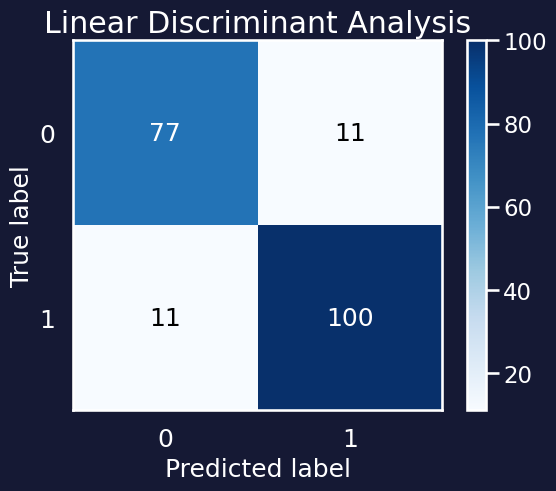

In [50]:
plot_confusion_matrix(y_test, LDA_predict, title="Linear Discriminant Analysis")

In [51]:
print(classification_report(y_test, LDA_predict))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        88
           1       0.90      0.90      0.90       111

    accuracy                           0.89       199
   macro avg       0.89      0.89      0.89       199
weighted avg       0.89      0.89      0.89       199

